<a href="https://colab.research.google.com/github/kihongMin/MLDL/blob/master/add_zeropadding.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import cv2


In [2]:
!git clone "https://github.com/parrotProj/proj1.git"

fatal: destination path 'proj1' already exists and is not an empty directory.


In [3]:
cd proj1

/content/proj1


In [0]:
import Resize

In [5]:
X_train,Y_train = Resize.train(160)
X_test,X_id = Resize.test(160)

input_size :  160


In [6]:
from tensorflow.keras.utils import to_categorical
Y_train = to_categorical(Y_train)

In [7]:
import keras.layers
import tensorflow as tf
from keras import backend as K
from keras.layers.core import Lambda
from keras.layers import Dropout

Using TensorFlow backend.


In [0]:
def zeropad(x):
    y = K.zeros(K.shape(x))
    return K.concatenate([x, y],-1)


def zeropad_output_shape(input_shape):
    shape = list(input_shape)
    assert len(shape) == 4
    shape[-1] *= 2
    return tuple(shape)


In [0]:
from keras import Input
from keras.models import Model
from keras.layers import BatchNormalization, Convolution2D, MaxPooling2D
from keras.layers import GlobalAveragePooling2D, Dense, Activation, Dropout
from keras.layers import Add, ZeroPadding2D, Flatten
'''
## 이미지 사이즈 너무 작아서 원래 인풋에서 7x7로 맥스풀링하던거 빼버림
## 대신에 3x3 layer 2개 붙여서  첫번째거에서는 stride=(1,1), padding='same'
##                          두번째거에서는 stride=(2,2), padding='same'
                            으로 5x5 conv로 다운사이징 해보자.
'''
def input_block(x):
    
    x = Convolution2D(32, (3,3), strides = (1,1),padding='same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Convolution2D(32, (3,3), strides = (1,1), padding='same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Convolution2D(32, (3,3), strides = (2,2), padding='same', kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)    
    return x

In [0]:
def bottle_neck(x,channels,d_increase=False):
    channel_1,channel_2,channel_3 = channels
    shortcut = x  
    #인풋 1x1 conV        
    x = Convolution2D(channel_1,kernel_size=(1,1),padding="same",kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x) 
        
    if d_increase == True:
 
        x = Convolution2D(channel_2,kernel_size=(3,3),strides=(2,2), padding = "same", kernel_initializer = 'he_normal')(x)        
        x = BatchNormalization()(x)
        x = Activation('relu')(x)

        shortcut = MaxPooling2D((2,2))(shortcut)
        #shortcut = keras.layers.concatenate([shortcut,K.zeros(K.shape(shortcut))])
        shortcut = Lambda(zeropad, output_shape=zeropad_output_shape)(shortcut)
    else:    
        x = Convolution2D(channel_2, kernel_size=(3,3), padding = "same", kernel_initializer = 'he_normal')(x)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        

    #1x1 conv 차원 복원    
    x = Convolution2D(channel_3, kernel_size=(1,1), padding = "same", kernel_initializer = 'he_normal')(x)
    x = BatchNormalization()(x)
    shortcut = BatchNormalization()(shortcut)
    
    x = Add()([x,shortcut])
    x = Activation('relu')(x)
    
    return x

In [0]:
def block_group(x, channels, num_blocks):
    for i in range(num_blocks):    
        if i==0:    
            x = bottle_neck(x,channels,True)            
        else:
            x = bottle_neck(x,channels,False)    
    return x

In [0]:
def result(x):
    input_data=x            #150 * 150 *3
    x = input_block(x)
    
    x = block_group(x, [16,16,64], 3)    
    x = block_group(x, [32,32,128], 4)
    x = block_group(x, [64,64,256], 6)
    x = block_group(x, [128,128,512], 3)
    
    x = GlobalAveragePooling2D()(x)
    output_data = Dense(6,activation='softmax')(x)
    
    model = Model(input_data,output_data)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
        
    return model

In [13]:
inputs = Input(shape=(160,160,3),dtype='float32')
model = result(inputs)

In [14]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 160, 160, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 160, 160, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 160, 160, 32) 128         conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 160, 160, 32) 0           batch_normalization_1[0][0]      
____________________________________________________________________________________________

In [0]:
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(shear_range=0.05, width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   horizontal_flip=True, zoom_range=0.2,)
from sklearn.model_selection import train_test_split

X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_train,Y_train, test_size=0.2)

In [0]:
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

es = EarlyStopping(monitor='val_loss',restore_best_weights=True, patience=30)
mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)

In [30]:
train_generator = train_datagen.flow(X_Train,Y_Train,batch_size=128)
hist=model.fit_generator(train_generator,steps_per_epoch=len(X_Train)/128,validation_data=(X_Val,Y_Val),
               validation_steps=128,epochs=60,callbacks=[es,mc])

Epoch 1/60
88/87 [==============================] - 102s 1s/step - loss: 0.8470 - acc: 0.6768 - val_loss: 1.2657 - val_acc: 0.5411
Epoch 2/60
88/87 [==============================] - 97s 1s/step - loss: 0.7686 - acc: 0.7110 - val_loss: 1.1683 - val_acc: 0.6462
Epoch 3/60
88/87 [==============================] - 98s 1s/step - loss: 0.6850 - acc: 0.7431 - val_loss: 1.8395 - val_acc: 0.5533
Epoch 4/60
88/87 [==============================] - 98s 1s/step - loss: 0.6658 - acc: 0.7518 - val_loss: 0.6493 - val_acc: 0.7492
Epoch 5/60
88/87 [==============================] - 98s 1s/step - loss: 0.6019 - acc: 0.7781 - val_loss: 0.6192 - val_acc: 0.7731
Epoch 6/60
88/87 [==============================] - 98s 1s/step - loss: 0.5790 - acc: 0.7873 - val_loss: 0.5460 - val_acc: 0.7962
Epoch 7/60
88/87 [==============================] - 97s 1s/step - loss: 0.5412 - acc: 0.7989 - val_loss: 0.6424 - val_acc: 0.7560
Epoch 8/60
88/87 [==============================] - 98s 1s/step - loss: 0.5141 - acc: 0.8

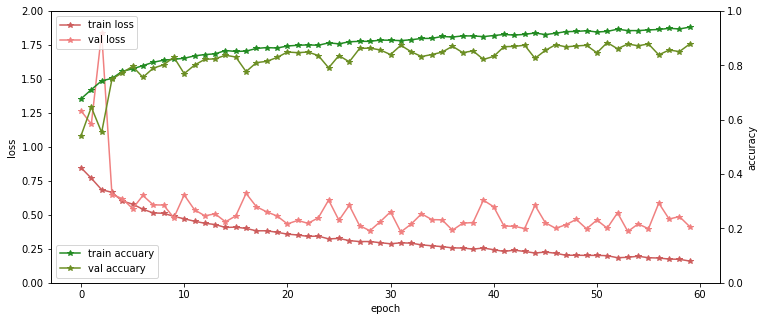

In [32]:
fig,loss_ax=plt.subplots(figsize=(12,5))
acc_ax=loss_ax.twinx()

loss_ax.plot(hist.history['loss'],'indianred',marker='*',label='train loss')
loss_ax.plot(hist.history['val_loss'],'lightcoral',marker='*',label='val loss')


loss_ax.set_ylim([0, 2])


acc_ax.plot(hist.history['acc'],'forestgreen',marker='*',label='train accuary')
acc_ax.plot(hist.history['val_acc'],'olivedrab',marker='*',label='val accuary')
acc_ax.set_ylim([0, 1])


loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')

loss_ax.legend(loc='upper left')
acc_ax.legend(loc='lower left')

plt.show()

In [0]:
model.load_weights('best_model.h5')

In [0]:
files.download('best_model.h5')

In [0]:
#모델 저장 및 가중치 저장

from google.colab import files
model.save_weights("model_weight.h5")
files.download("model_weight.h5")

model.save('bottle_model.h5')
files.download("bottle_model.h5")

In [0]:
result = model.predict(X_test,batch_size=128)
result = np.argmax(result,axis=1).reshape(-1,1)

output = pd.DataFrame(X_id)
output['pred_label'] = result
output.columns = ['id','pred_label']
output = output.set_index('id')

In [0]:
output.to_csv('prediction.csv')


files.download("prediction.csv")

In [38]:
output['count']=1
output.groupby('pred_label').sum()

,count
pred_label,
0,509
1,565
2,568
3,354
4,520
5,484
